In [1]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# dataset functions
from dataset import load_util

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.simclr import *
from models.simclr.transforms import *
from models.rotnet.rotnet import *
from models.rotnet.IDEC import *
from models.rotnet.custom_stl10 import *
from cluster_accuracy import cluster_accuracy

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

Versions:
torch: 1.8.1+cu111
torchvision: 0.9.1+cu111
numpy: 1.19.5
scikit-learn: 0.24.1
Using device:  cuda


In [4]:
# specify learning params
batch_size = 128
learning_rate = 0.1
epochs = 100

# training

train = True

### Clustering and PCA of the pretrained RotNet model 

In [25]:
test_data = load_util.load_custom_cifar('./data', download=False, train=False, data_percent=1.0, for_model='SimCLR', transforms=False)
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=128,
                                          shuffle=True,
                                          drop_last=True)

In [26]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}

In [170]:
# for i in range(3):
model = RotNet(num_classes=4)

state_dict = torch.load(f'trained_models/pretrained_RotNet_features.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

print(model.feat_block_names)

['conv1', 'conv2', 'conv3', 'pooling', 'features', 'classifier']


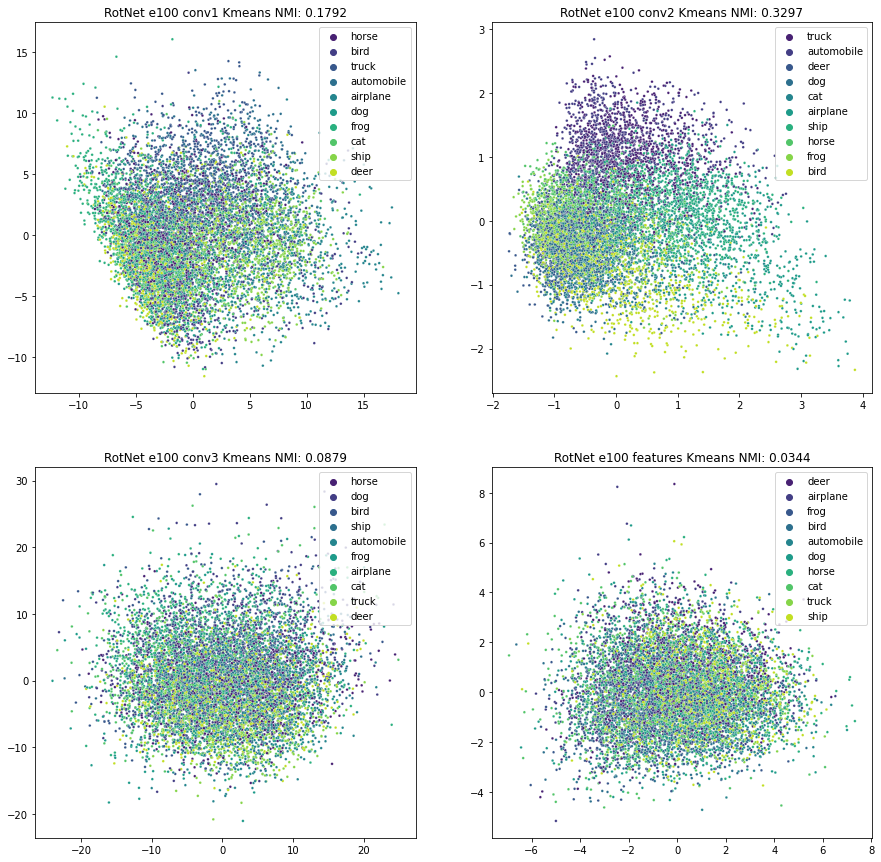

In [85]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    ver = f'RotNet e100 {layer}'
    embedded_data, labels = encode_batchwise(testloader, model, device, [layer], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embedded_data)

    axes[i].set_title(f'{ver} Kmeans NMI: {nmi:.4f}')
    sns.scatterplot(ax=axes[i], x=reduced_data[:,0], y=reduced_data[:,1], hue=lable_classes, s=7, palette='viridis')

### RotNet IDEC

In [37]:
name = 'IDEC_RotNet_e100_features.pth'
rotnet = load_model(name, device, torch.rand(size=(4, 10)))

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


IDEC_RotNet_e100_features.pth
Starting encoding...
Starting KMeans...
Starting PCA...
IDEC_RotNet_e100_features.pth
Starting encoding...
Starting KMeans...
Starting PCA...
IDEC_RotNet_e100_features.pth
Starting encoding...
Starting KMeans...
Starting PCA...
IDEC_RotNet_e100_features.pth
Starting encoding...
Starting KMeans...
Starting PCA...


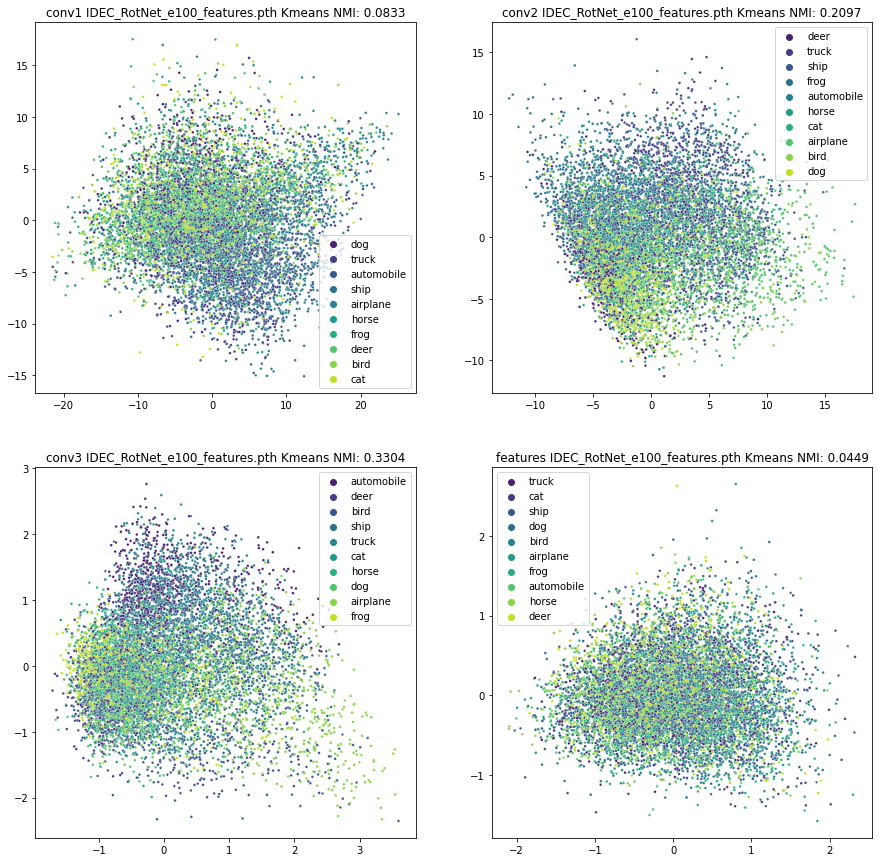

In [32]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    flatten = 'conv' in layer
    _, _, nmi, pca, lable_classes = compute_nmi_and_pca(rotnet,
                                                        name,
                                                        colors_classes,
                                                        device,
                                                        testloader,
                                                        layer=layer,
                                                        flatten=flatten)
    plot_pca_and_nmi(f'{layer} {name}', axes[i], nmi, pca, lable_classes)

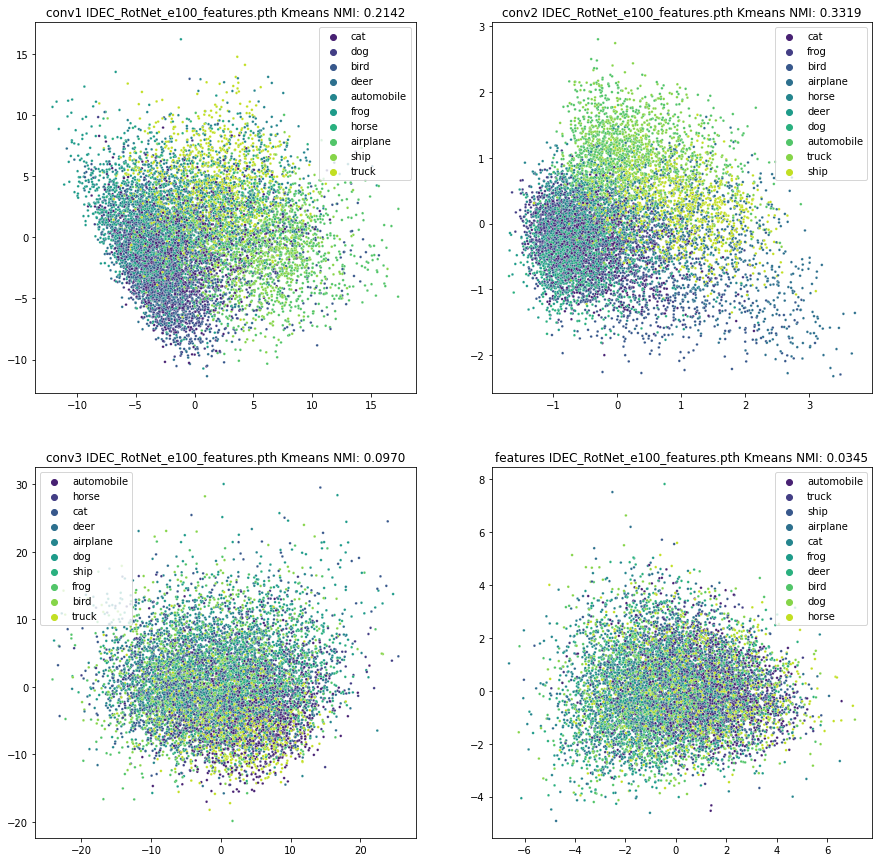

In [38]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    flatten = 'conv' in layer
    _, _, nmi, pca, lable_classes = compute_nmi_and_pca(rotnet,
                                                        name,
                                                        colors_classes,
                                                        device,
                                                        testloader,
                                                        layer=layer,
                                                        flatten=flatten)
    plot_pca_and_nmi(f'{layer} {name}', axes[i], nmi, pca, lable_classes)

In [25]:
names = ['pretrained_RotNet_features.pth', 'IDEC_RotNet_e100_features.pth']
pcas = {}
nmis = {}

In [ ]:
for name in names:
    rotnet = load_model(name, device, torch.rand(size=(4, 10)))
    _, _, nmi, pca, lable_classes = compute_nmi_and_pca(rotnet,
                                                        name,
                                                        colors_classes,
                                                        device,
                                                        testloader,
                                                        layer='features',
                                                        flatten=False)
    pcas[name] = pca
    nmis[name] = nmi

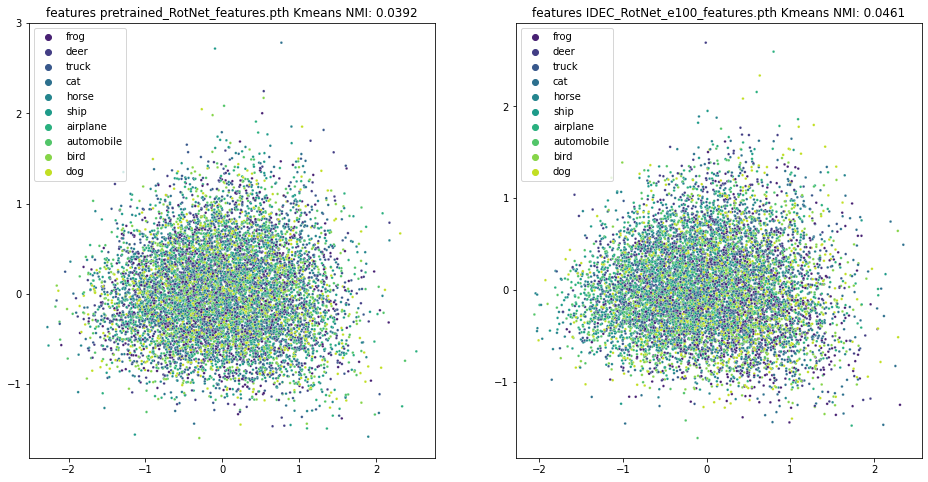

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes = axes.flatten()

for i, name in enumerate(names):
    plot_pca_and_nmi(f'{layer} {name}', axes[i], nmis[name], pcas[name], lable_classes)

As we have discussed last Friday, I have tried to add an additional linear layer with 10 output dimensions, but as we see, clustering based on features was not really successful. I have read the paper again and have noticed the following: they also pretrain the model to get relevant features, and then use the output from one of the inner convolutional layers (2d is the best) to train a classifier in a supervised way, so they use the true labels. 

So I kind of have a problem here: I either need to use true labels to continue training with cross entropy, because cross entropy loss needs some kind of labels, or I can use some other loss which would make sense with convolution network output activations as input.

But since I could not perform IDEC, I decided to try to perform DEC to see what will happen, because in case of DEC I don't need a model's training loss and because I thought that probably in case where we don't really have "reconstruction" of the images the distortion of the features won't be that bad.

pretrained_RotNet_features.pth class representation


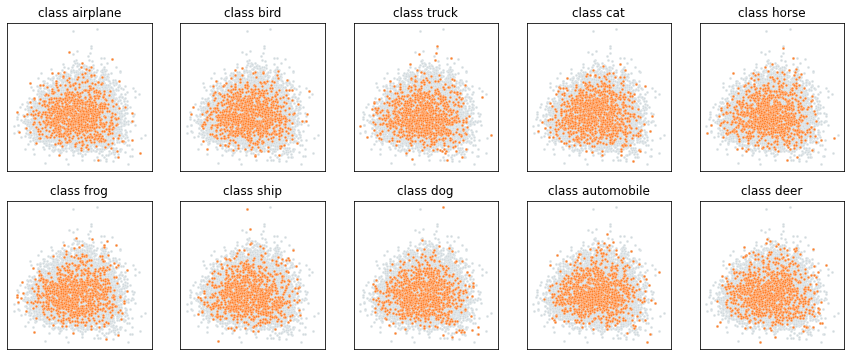

IDEC_RotNet_e100_features.pth class representation


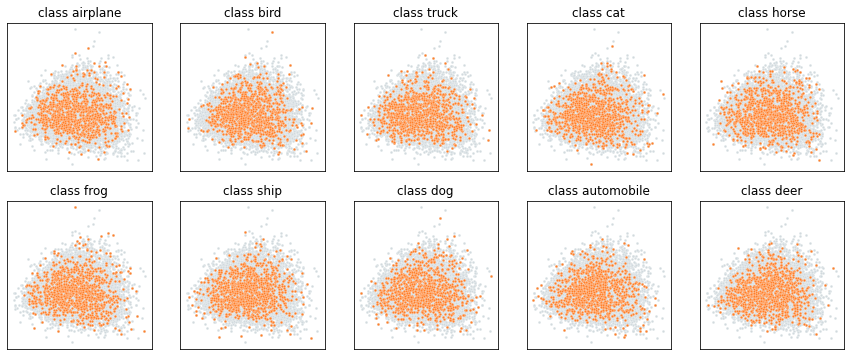

In [34]:
for name in names:
    plot_class_representation(pcas[name], name, lable_classes)

### RotNet DEC

In [ ]:
name = 'DEC_RotNet_50.pth'
rotnet = load_model(name, device)

In [ ]:
labels, kmeans, nmi, reduced_data, lable_classes = compute_nmi_and_pca(rotnet, name, colors_classes, device, testloader)

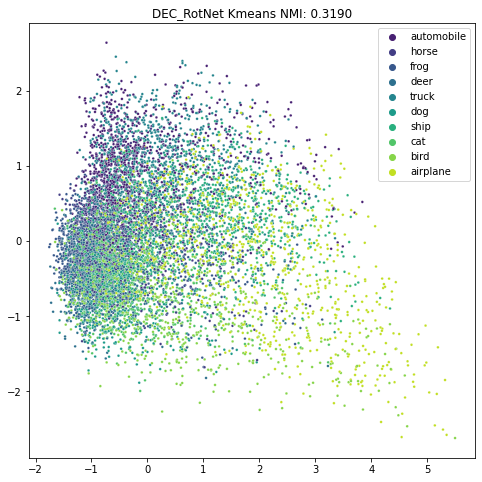

In [20]:
fig, axes = plt.subplots(figsize=(8,8))
plot_pca_and_nmi(rotnet_dec.name, axes, nmi, reduced_data, lable_classes)

DEC_RotNet class representation


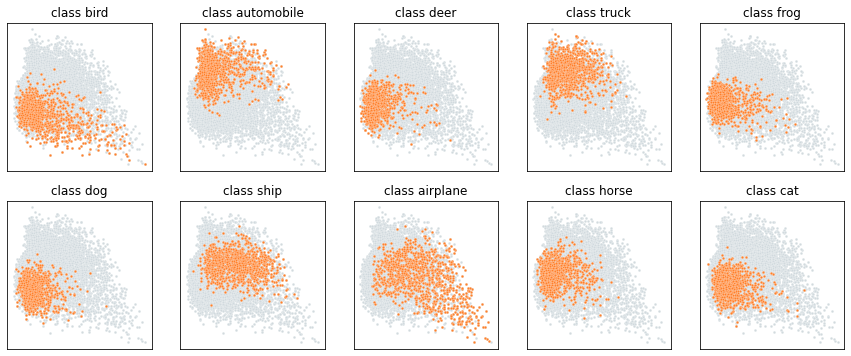

In [22]:
plot_class_representation(reduced_data, rotnet_dec.name, lable_classes)

## Cluster accuracy and Confusion Matrix

In [33]:
names = ['pretrained_RotNet_features.pth', 'DEC_RotNet.pth']

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


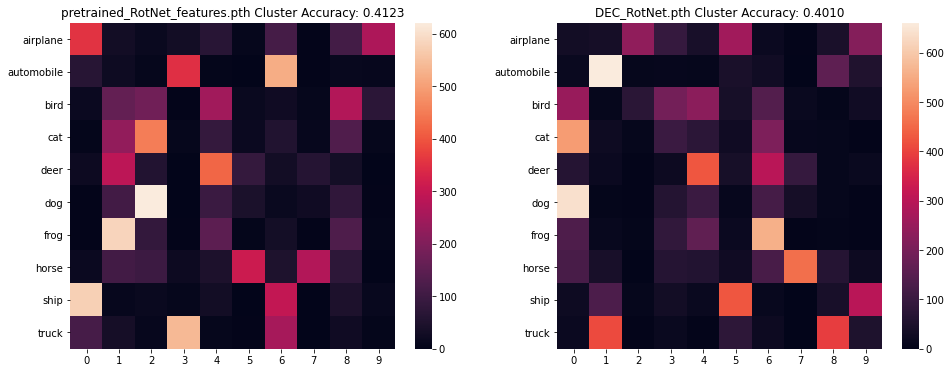

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

for i, name in enumerate(names):
    model = load_model(name, device)
    labels, kmeans, _, _, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)
    rotnet_ca = cluster_accuracy(labels, kmeans.labels_)
    cm = confusion_matrix(labels, kmeans.labels_, labels=list(range(len(test_data.classes))), normalize=None)
    axes[i].set(title=f'{name} Cluster Accuracy: {rotnet_ca:.4f}')
    sns.heatmap(cm, yticklabels=test_data.classes, ax=axes[i])

The cluster accuracy is much better than original DEC cluster accuracy (30.1 according to the paper you've sent), but unfortunately one can see that the DEC does not really improve the results of pretraining.

## RotNet with Adam Optimizer

While going through my code, I have noticed that I used SDG Optimizer for training RotNet DEC. I though that it could affect the results in a negative way, since DEC is originally trained with Adam optimizer. So I tried to train the RotNet with Adam optimizer, and this was the result.

In [9]:
name = 'DEC_RotNet_Cube_Adam50.pth'
rotnet = load_model(name, device)
labels, kmeans, nmi, reduced_data, lable_classes = compute_nmi_and_pca(rotnet, name, colors_classes, device, testloader)

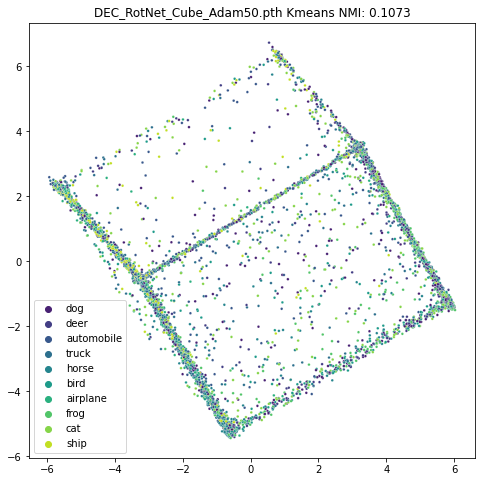

In [11]:
fig, axes = plt.subplots(figsize=(8, 8))
plot_pca_and_nmi(name, axes, nmi, reduced_data, lable_classes)

DEC_RotNet_Cube_Adam50.pth class representation


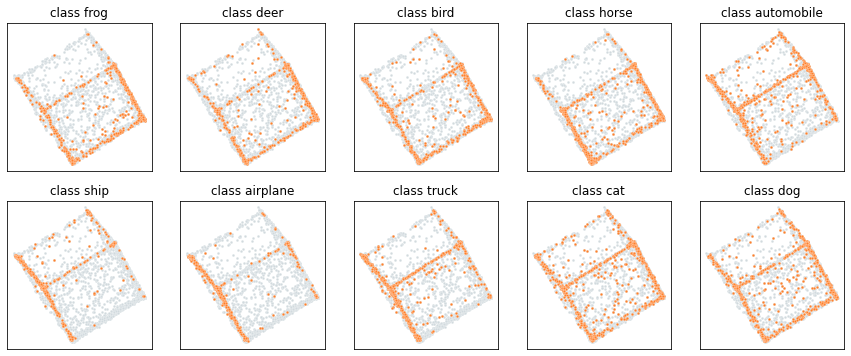

In [12]:
plot_class_representation(reduced_data, name, lable_classes)

## RotNet with Augmented DEC

Unfortunately using augmented data together with clean data to compute DEC loss has made the results even worse. I am not sure why is this happening, my guess is that false predictions for non-augmented data draw predictions for augmented data in false direction. We can go through the code together during the meeting, but I think I implemented it correctly.

In [34]:
name = 'DEC_RotNet_aug_50.pth'
model = load_model(name, device=device)

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


In [174]:
labels, kmeans, nmi, reduced_data, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)

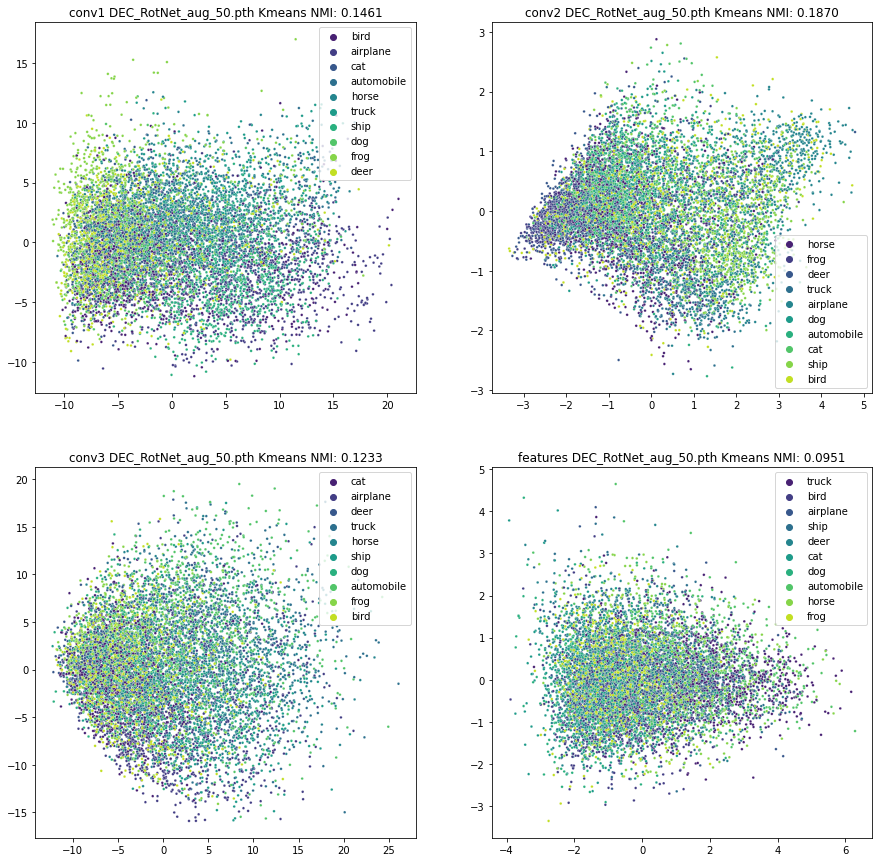

In [35]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    flatten = 'conv' in layer
    _, _, nmi, pca, lable_classes = compute_nmi_and_pca(model,
                                                        name,
                                                        colors_classes,
                                                        device,
                                                        testloader,
                                                        layer=layer,
                                                        flatten=flatten)
    plot_pca_and_nmi(f'{layer} {name}', axes[i], nmi, pca, lable_classes)

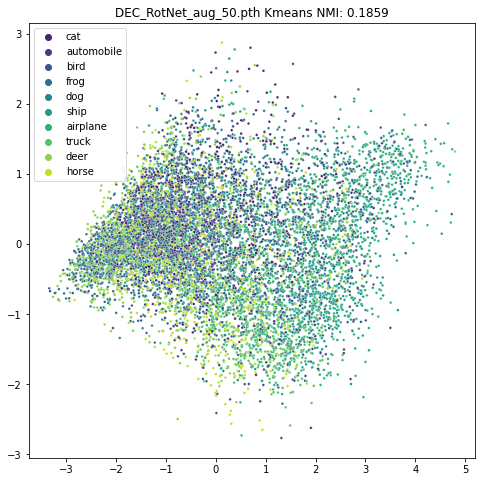

In [175]:
fig, axes = plt.subplots(figsize=(8, 8))
plot_pca_and_nmi(name, axes, nmi, reduced_data, lable_classes)

DEC_RotNet_aug_50.pth class representation


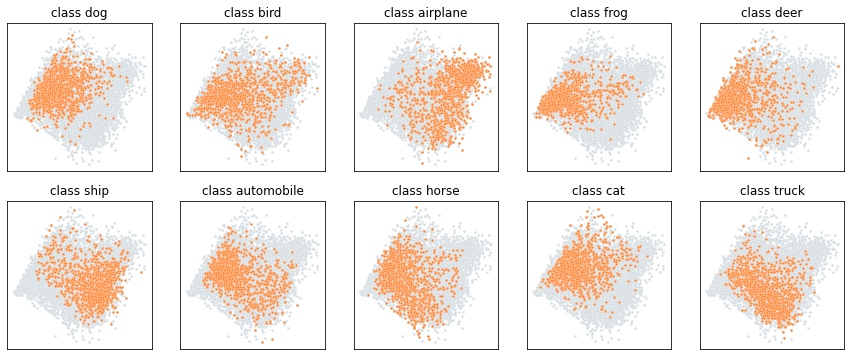

In [176]:
plot_class_representation(reduced_data, name, lable_classes)

<AxesSubplot:title={'center':'DEC_RotNet_aug_50.pth Cluster Accuracy: 0.2974'}>

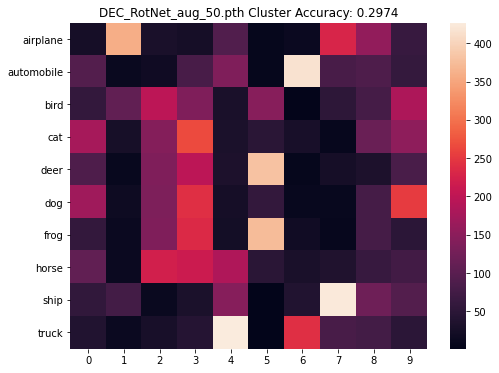

In [178]:
fig, axes = plt.subplots(figsize=(8, 6))
rotnet_ca = cluster_accuracy(labels, kmeans.labels_)
cm = confusion_matrix(labels, kmeans.labels_, labels=list(range(len(test_data.classes))), normalize=None)
axes.set(title=f'{name} Cluster Accuracy: {rotnet_ca:.4f}')
sns.heatmap(cm, yticklabels=test_data.classes, ax=axes)

## RotNet 10 pretrainings

In [ ]:
nmis = {}
cas = {}

for i in range(0,9):
    name = f'pretrained_RotNet_{i}.pth'
    print(name)
    
    model = load_model(name, device, torch.rand(size=(4, 10)))
    nmis[i] = []
    cas[i] = []
    
    for k in range(10):
        labels, kmeans, nmi, pca, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)
        nmis[i].append(nmi)

        ca = cluster_accuracy(labels, kmeans.labels_)
        cas[i].append(ca)
        print(f'Run: {k}\n{name}:\nNMI:{nmi}\nCA:{ca}\n')

In [7]:
df_nmis = pd.read_csv('statistics\RotNet\pretrained_nmis.csv')
df_cas = pd.read_csv('statistics\RotNet\pretrained_cas.csv')

In [8]:
nmis_mean = df_nmis.mean()
cas_mean = df_cas.mean()

nmis_mean_total = nmis_mean.mean()
cas_mean_total = cas_mean.mean()

In [9]:
print(f'NMI average for each model: \n{nmis_mean}\n')
print(f'Cluster accuracy average for each model: \n{cas_mean}\n')

print(f'Total NMI average: {nmis_mean_total:.2f}')
print(f'Total cluster accuracy average: {cas_mean_total:.2f}')

NMI average for each model: 
pretrained_RotNet_0.pth    0.343902
pretrained_RotNet_1.pth    0.360109
pretrained_RotNet_2.pth    0.354172
pretrained_RotNet_3.pth    0.351038
pretrained_RotNet_4.pth    0.355731
pretrained_RotNet_5.pth    0.357575
pretrained_RotNet_6.pth    0.353100
pretrained_RotNet_7.pth    0.354531
pretrained_RotNet_8.pth    0.340263
dtype: float64

Cluster accuracy average for each model: 
pretrained_RotNet_0.pth    0.460847
pretrained_RotNet_1.pth    0.456741
pretrained_RotNet_2.pth    0.436458
pretrained_RotNet_3.pth    0.404557
pretrained_RotNet_4.pth    0.402374
pretrained_RotNet_5.pth    0.434325
pretrained_RotNet_6.pth    0.443219
pretrained_RotNet_7.pth    0.440194
pretrained_RotNet_8.pth    0.445333
dtype: float64

Total NMI average: 0.35
Total cluster accuracy average: 0.44


NMI and Cluster Accuracy on the whole dataset are slightly better than on the 40% of data.

## RotNet DEC with PCA

I have tried training with the DEC on the activations provided by the second convolutional block reduced with PCA. I have tried dimensionalities of 256 and 512. As you can see it did not really improved the results. The loss just wasn't going down and the final result is not better than the training on not reduced data.

In [47]:
name = 'DEC_RotNet_PCA_256.pth'
idec_model = load_model(name, device, cluster_centres=torch.rand(size=(10, 256)))

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


In [48]:
labels, kmeans, nmi, reduced_data, lable_classes = compute_nmi_and_pca(idec_model, name, colors_classes, device, testloader)

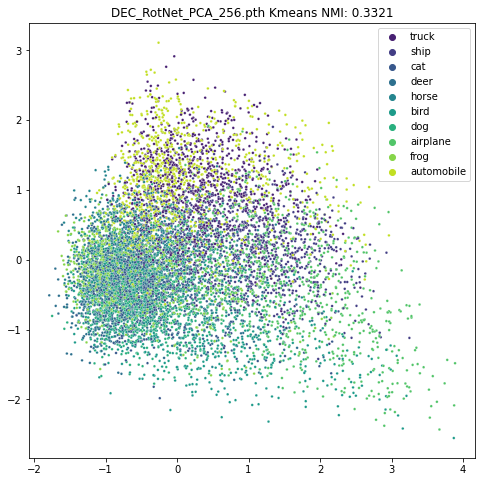

In [49]:
fig, axes = plt.subplots(figsize=(8, 8))
plot_pca_and_nmi(name, axes, nmi, reduced_data, lable_classes)

DEC_RotNet_PCA_256.pth class representation


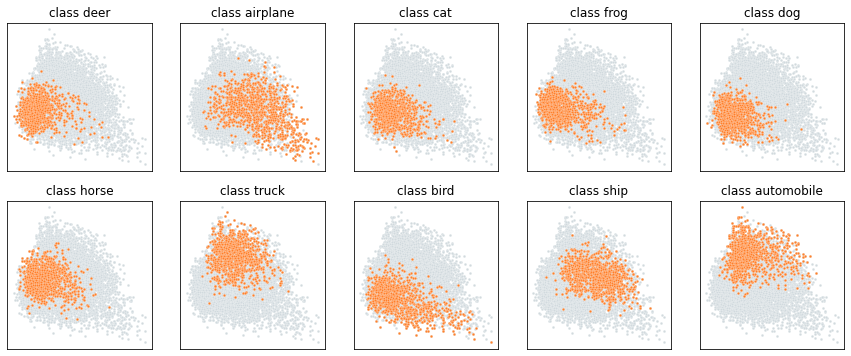

In [50]:
plot_class_representation(reduced_data, name, lable_classes)

In [55]:
name = 'DEC_RotNet_PCA_512.pth'
idec_model = load_model(name, device, cluster_centres=torch.rand(size=(10, 512)))

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


In [56]:
labels, kmeans, nmi, reduced_data, lable_classes = compute_nmi_and_pca(idec_model, name, colors_classes, device, testloader)

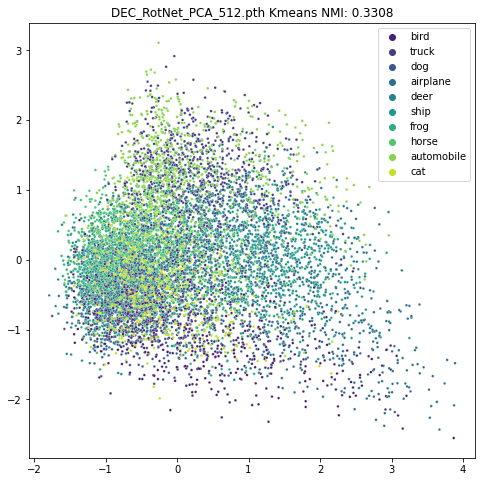

In [57]:
fig, axes = plt.subplots(figsize=(8, 8))
plot_pca_and_nmi(name, axes, nmi, reduced_data, lable_classes)

DEC_RotNet_PCA_512.pth class representation


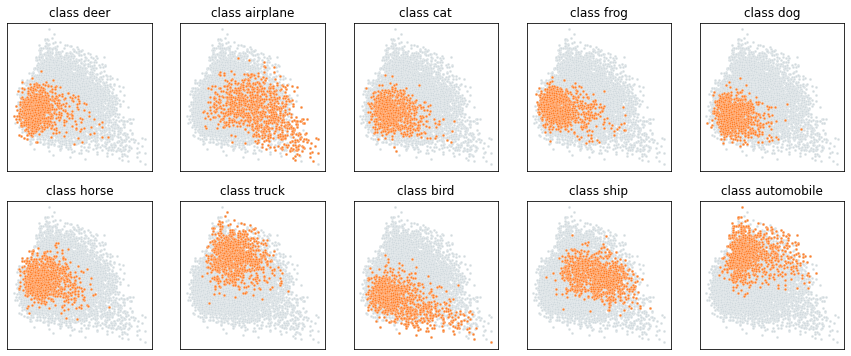

In [58]:
plot_class_representation(reduced_data, name, lable_classes)

## RotNet with STL-10 (Images resized from 96 x 96 to 32 x 32)

In [37]:
nmis = {}
pcas = {}
lcs = {}
cas = {}
cms = {}

In [38]:
names = ['pretrained_RotNet_STL10.pth', 'DEC_RotNet_STL10_50.pth']

In [43]:
for name in names:
    model = load_model(name, device, cluster_centres=torch.rand(size=(4, 12288)))
    labels, kmeans, nmis[name], pcas[name], lcs[name] = compute_nmi_and_pca(model, name, colors_classes, device, testloader)
    cas[name] = cluster_accuracy(labels, kmeans.labels_)
    cms[name] = confusion_matrix(labels, kmeans.labels_, labels=list(range(len(test_stl10.classes))), normalize=None)

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


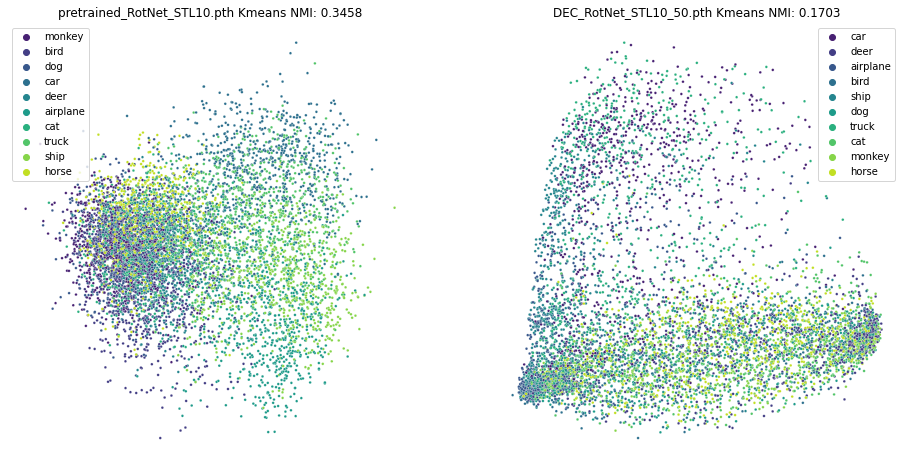

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes = axes.flatten()

for i, name in enumerate(names):
    plot_pca_and_nmi(name, axes[i], nmis[name], pcas[name], lcs[name])

pretrained_RotNet_STL10.pth class representation


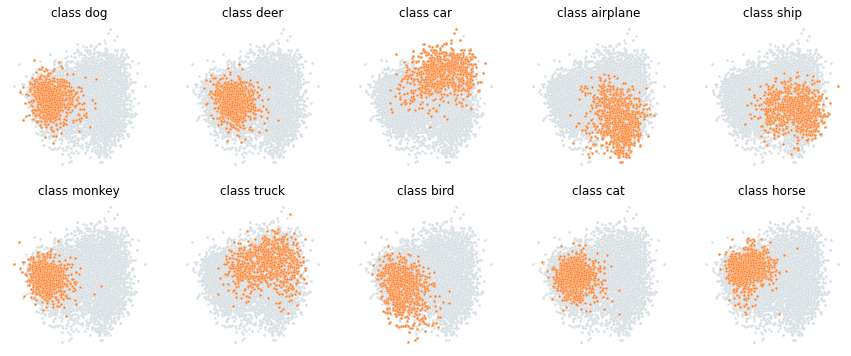

DEC_RotNet_STL10_50.pth class representation


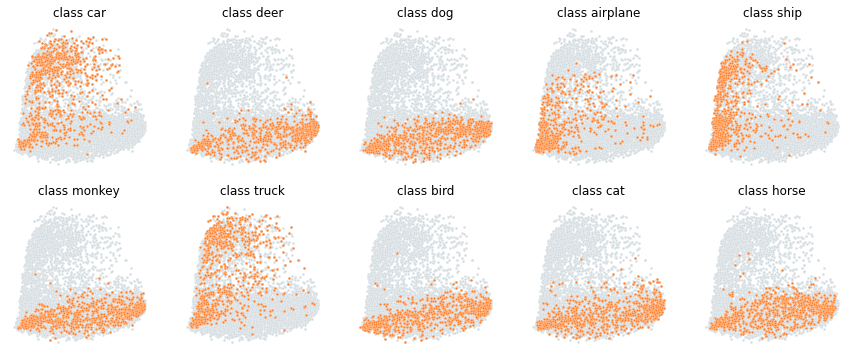

In [46]:
for name in names:
    plot_class_representation(pcas[name], name, lcs[name])

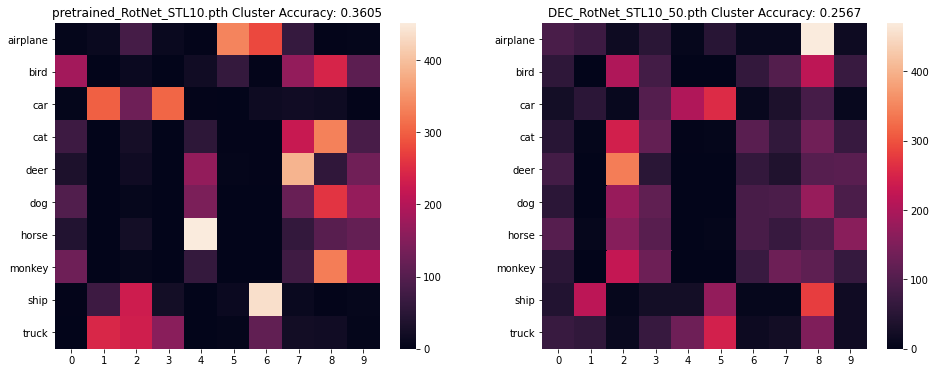

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

for i, name in enumerate(names):
    axes[i].set(title=f'{name} Cluster Accuracy: {cas[name]:.4f}')
    sns.heatmap(cms[name], yticklabels=test_stl10.classes, ax=axes[i])

Questions:
- Train DEC CIFAR with aug or non-aug DEC?
- Is ok to do final STL training for a table results on resized images, or should they be the original size?

In [24]:
from models.rotnet.custom_cifar import RotNetCIFARForPlot

In [35]:
rt_cifar = RotNetCIFARForPlot('./data', False)
rt_loader = torch.utils.data.DataLoader(rt_cifar,
                                          batch_size=128,
                                          shuffle=True,
                                          drop_last=True)

In [37]:
colors_classes = {i: color_class for i, color_class in zip(range(len(rt_cifar.classes)), rt_cifar.classes)}

In [34]:
name = 'DEC_RotNet_aug_50.pth'
model = load_model(name, device=device)

In [39]:
labels, aug_labels, kmeans, nmi, pca, lable_classes = compute_nmi_and_pca_for_plot(model, name, colors_classes, device, rt_loader)

DEC_RotNet_aug_50.pth class representation


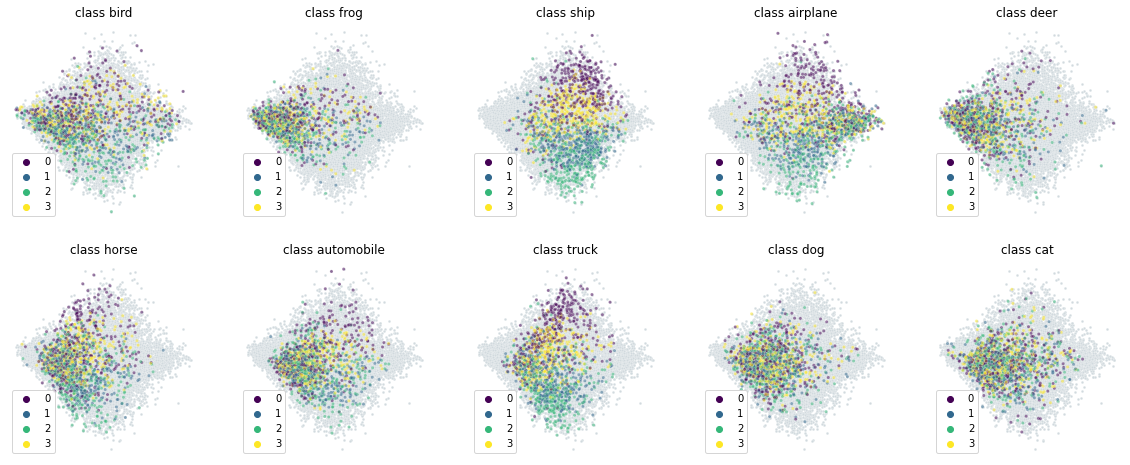

In [63]:
plot_class_representation_rotnet(pca, name, lable_classes, aug_labels)

In [5]:
from models.rotnet.custom_stl10 import RotNetSTL10
from models.rotnet.rotnet import RotNet
from models.simclr.custom_stl10 import SimCLRSTL10

In [6]:
stl10 = RotNetSTL10(data_percent=1.0)
dataloader = torch.utils.data.DataLoader(stl10,
                                         batch_size=128,
                                         shuffle=True,
                                         drop_last=True)

In [7]:
eval_data = RotNetSTL10(data_percent=1.0, train=False)
eval_dataloader = torch.utils.data.DataLoader(eval_data,
                                         batch_size=128,
                                         shuffle=True,
                                         drop_last=True)

In [7]:
i=2

In [8]:
model = load_model(f'RotNet\STL10\pretrained_RotNet_STL10_{i}.pth', device, cluster_centres=torch.rand(size=(4, 12288)))
idec_model = IDEC(model, dataloader, device)
idec_model.name = f'{idec_model.name}_STL10_{i}'.replace('pretrained','')
print(idec_model.name)

DEC_RotNet_STL10_2


In [10]:
train_model(idec_model, 128, 0.001, 500, dataloader, True, device, eval_dataloader)

Training DEC_RotNet_STL10_2 started...
DEC_RotNet_STL10_2: Epoch 1/500 - Iteration 3125 - Train loss:1.3745 Validation loss:1.3714, LR: 0.0001
Validation loss decreased (inf --> 1.371418).  Saving model ...
Validation loss decreased (1.371418 --> 1.366375).  Saving model ...
Validation loss decreased (1.366375 --> 1.361016).  Saving model ...
Validation loss decreased (1.361016 --> 1.354304).  Saving model ...
Validation loss decreased (1.354304 --> 1.345509).  Saving model ...
DEC_RotNet_STL10_2: Epoch 6/500 - Iteration 18750 - Train loss:1.3412 Validation loss:1.3306, LR: 0.0001
Validation loss decreased (1.345509 --> 1.330570).  Saving model ...
Validation loss decreased (1.330570 --> 1.301151).  Saving model ...
Validation loss decreased (1.301151 --> 1.250821).  Saving model ...
Validation loss decreased (1.250821 --> 1.184355).  Saving model ...
Validation loss decreased (1.184355 --> 1.109028).  Saving model ...
DEC_RotNet_STL10_2: Epoch 11/500 - Iteration 34375 - Train loss:1.0

IDEC(
  (loss): CrossEntropyLoss()
  (model): RotNet(
    (loss): CrossEntropyLoss()
    (feat_blocks): ModuleList(
      (0): Sequential(
        (B1_ConvB1): RotNetBasicBlock(
          (block): Sequential(
            (0): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
            (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (B1_ConvB2): RotNetBasicBlock(
          (block): Sequential(
            (0): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (B1_ConvB3): RotNetBasicBlock(
          (block): Sequential(
            (0): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [11]:
for i in [0,1,3,4,5,6,7,8,9]:
    model = load_model(f'RotNet\STL10\pretrained_RotNet_STL10_{i}.pth', device, cluster_centres=torch.rand(size=(4, 12288)))
    idec_model = IDEC(model, dataloader, device)
    idec_model.name = f'{idec_model.name}_STL10_{i}'.replace('pretrained','')
    print(idec_model.name)
    train_model(idec_model, 128, 0.001, 500, dataloader, True, device, eval_dataloader)

DEC_RotNet_STL10_0
Training DEC_RotNet_STL10_0 started...
DEC_RotNet_STL10_0: Epoch 1/500 - Iteration 3125 - Train loss:1.3736 Validation loss:1.3723, LR: 0.0001
Validation loss decreased (inf --> 1.372329).  Saving model ...
Validation loss decreased (1.372329 --> 1.368084).  Saving model ...
Validation loss decreased (1.368084 --> 1.364026).  Saving model ...
Validation loss decreased (1.364026 --> 1.359497).  Saving model ...
Validation loss decreased (1.359497 --> 1.354149).  Saving model ...
DEC_RotNet_STL10_0: Epoch 6/500 - Iteration 18750 - Train loss:1.3458 Validation loss:1.3473, LR: 0.0001
Validation loss decreased (1.354149 --> 1.347279).  Saving model ...
Validation loss decreased (1.347279 --> 1.338423).  Saving model ...
Validation loss decreased (1.338423 --> 1.326390).  Saving model ...
Validation loss decreased (1.326390 --> 1.310086).  Saving model ...
Validation loss decreased (1.310086 --> 1.288505).  Saving model ...
DEC_RotNet_STL10_0: Epoch 11/500 - Iteration 343

Validation loss decreased (0.442138 --> 0.440422).  Saving model ...
Validation loss decreased (0.440422 --> 0.436980).  Saving model ...
Validation loss decreased (0.436980 --> 0.436261).  Saving model ...
Validation loss decreased (0.436261 --> 0.432213).  Saving model ...
DEC_RotNet_STL10_0: Epoch 101/500 - Iteration 315625 - Train loss:0.4287 Validation loss:0.4297, LR: 0.0001
Validation loss decreased (0.432213 --> 0.429656).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
Validation loss decreased (0.429656 --> 0.423773).  Saving model ...
EarlyStopping counter: 1 out of 10
DEC_RotNet_STL10_0: Epoch 106/500 - Iteration 331250 - Train loss:0.4180 Validation loss:0.4198, LR: 0.0001
Validation loss decreased (0.423773 --> 0.419757).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation loss decreased (0.419757 --> 0.413786).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation loss decreased (0.413786 --> 0.413329).  Savin

Validation loss decreased (1.366177 --> 1.361599).  Saving model ...
Validation loss decreased (1.361599 --> 1.356378).  Saving model ...
Validation loss decreased (1.356378 --> 1.349738).  Saving model ...
DEC_RotNet_STL10_1: Epoch 6/500 - Iteration 18750 - Train loss:1.3447 Validation loss:1.3403, LR: 0.0001
Validation loss decreased (1.349738 --> 1.340282).  Saving model ...
Validation loss decreased (1.340282 --> 1.325328).  Saving model ...
Validation loss decreased (1.325328 --> 1.297741).  Saving model ...
Validation loss decreased (1.297741 --> 1.248535).  Saving model ...
Validation loss decreased (1.248535 --> 1.181047).  Saving model ...
DEC_RotNet_STL10_1: Epoch 11/500 - Iteration 34375 - Train loss:1.1585 Validation loss:1.1161, LR: 0.0001
Validation loss decreased (1.181047 --> 1.116128).  Saving model ...
Validation loss decreased (1.116128 --> 1.059849).  Saving model ...
Validation loss decreased (1.059849 --> 1.019397).  Saving model ...
Validation loss decreased (1.0

DEC_RotNet_STL10_3: Epoch 11/500 - Iteration 34375 - Train loss:1.2823 Validation loss:1.2513, LR: 0.0001
Validation loss decreased (1.300509 --> 1.251337).  Saving model ...
Validation loss decreased (1.251337 --> 1.188988).  Saving model ...
Validation loss decreased (1.188988 --> 1.127578).  Saving model ...
Validation loss decreased (1.127578 --> 1.066591).  Saving model ...
Validation loss decreased (1.066591 --> 1.016284).  Saving model ...
DEC_RotNet_STL10_3: Epoch 16/500 - Iteration 50000 - Train loss:1.0138 Validation loss:0.9809, LR: 0.0001
Validation loss decreased (1.016284 --> 0.980948).  Saving model ...
Validation loss decreased (0.980948 --> 0.949884).  Saving model ...
Validation loss decreased (0.949884 --> 0.920282).  Saving model ...
Validation loss decreased (0.920282 --> 0.897866).  Saving model ...
Validation loss decreased (0.897866 --> 0.869525).  Saving model ...
DEC_RotNet_STL10_3: Epoch 21/500 - Iteration 65625 - Train loss:0.8733 Validation loss:0.8531, LR:

Validation loss decreased (0.958572 --> 0.929266).  Saving model ...
Validation loss decreased (0.929266 --> 0.909103).  Saving model ...
DEC_RotNet_STL10_4: Epoch 21/500 - Iteration 65625 - Train loss:0.8898 Validation loss:0.8908, LR: 0.0001
Validation loss decreased (0.909103 --> 0.890803).  Saving model ...
Validation loss decreased (0.890803 --> 0.879781).  Saving model ...
Validation loss decreased (0.879781 --> 0.855125).  Saving model ...
Validation loss decreased (0.855125 --> 0.845878).  Saving model ...
Validation loss decreased (0.845878 --> 0.834253).  Saving model ...
DEC_RotNet_STL10_4: Epoch 26/500 - Iteration 81250 - Train loss:0.8126 Validation loss:0.8180, LR: 0.0001
Validation loss decreased (0.834253 --> 0.818046).  Saving model ...
Validation loss decreased (0.818046 --> 0.806809).  Saving model ...
Validation loss decreased (0.806809 --> 0.798043).  Saving model ...
Validation loss decreased (0.798043 --> 0.776390).  Saving model ...
Validation loss decreased (0.

EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (0.302822 --> 0.296706).  Saving model ...
DEC_RotNet_STL10_4: Epoch 126/500 - Iteration 393750 - Train loss:0.2883 Validation loss:0.3129, LR: 0.0001
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (0.296706 --> 0.295377).  Saving model ...
DEC_RotNet_STL10_4: Epoch 131/500 - Iteration 409375 - Train loss:0.2833 Validation loss:0.2964, LR: 0.0001
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
Validation loss decreased (0.295377 --> 0.287775).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
DEC_RotNet_STL10_4: Epoch 136/500 - Iteration 425000 - Train loss:0.2784 Validation loss:0.2933, LR: 0.0001
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping 

RuntimeError: CUDA error: the launch timed out and was terminated

In [ ]:
for i in [5,6,7,8,9]:
    model = load_model(f'RotNet\STL10\pretrained_RotNet_STL10_{i}.pth', device, cluster_centres=torch.rand(size=(4, 12288)))
    idec_model = IDEC(model, dataloader, device)
    idec_model.name = f'{idec_model.name}_STL10_{i}'.replace('pretrained','')
    print(idec_model.name)
    train_model(idec_model, 128, 0.001, 500, dataloader, True, device, eval_dataloader)

In [9]:
def train_model(model, batch_size, learning_rate, epochs, data, train, device, eval_dl, degree_of_space_distortion=None):
    print(f"Training {model.name} started...")
    model = model.to(device)

    # paths to save/load models from
    base_path = "trained_models"
    pretrained_model_name = f"pretrained_{model.name}.pth"
    pretrained_model_path = os.path.join(base_path, pretrained_model_name)

    # training
    if train:

#         trainloader = torch.utils.data.DataLoader(data,
#                                                   batch_size=batch_size,
#                                                   shuffle=True,
#                                                   drop_last=True)
        trainloader = data

        if degree_of_space_distortion is None:
            model = model.fit(data_loader=trainloader, epochs=epochs, start_lr=learning_rate, device=device,
                              model_path=pretrained_model_path, eval_data_loader=eval_dl)
        else:
            model = model.fit(data_loader=trainloader, epochs=epochs, start_lr=learning_rate, device=device,
                              model_path=pretrained_model_path, degree_of_space_distortion=degree_of_space_distortion)
        torch.save(model.state_dict(), pretrained_model_path)
    else:
        state_dict = torch.load(pretrained_model_path, map_location=device)
        model.load_state_dict(state_dict)

    return model

In [13]:
def train_model(model, batch_size, learning_rate, epochs, data, train, device, degree_of_space_distortion=None):
    print(f"Training {model.name} started...")
    model = model.to(device)

    # paths to save/load models from
    base_path = "trained_models"
    pretrained_model_name = f"pretrained_{model.name}.pth"
    pretrained_model_path = os.path.join(base_path, pretrained_model_name)

    # training
    if train:

#         trainloader = torch.utils.data.DataLoader(data,
#                                                   batch_size=batch_size,
#                                                   shuffle=True,
#                                                   drop_last=True)
        trainloader = data

        if degree_of_space_distortion is None:
            model = model.fit(data_loader=trainloader, epochs=epochs, start_lr=learning_rate, device=device,
                              model_path=pretrained_model_path)
        else:
            model = model.fit(data_loader=trainloader, epochs=epochs, start_lr=learning_rate, device=device,
                              model_path=pretrained_model_path, degree_of_space_distortion=degree_of_space_distortion)
        torch.save(model.state_dict(), pretrained_model_path)
    else:
        state_dict = torch.load(pretrained_model_path, map_location=device)
        model.load_state_dict(state_dict)

    return model

In [14]:
from models.autoencoder.conv_ae import ConvAE
from models.autoencoder.custom_cifar import AECIFAR

In [15]:
data = AECIFAR('./data', data_percent=1.0)
dataloader = torch.utils.data.DataLoader(data,
                                         batch_size=128,
                                         shuffle=True,
                                         drop_last=True)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:75] data. DefaultCPUAllocator: not enough memory: you tried to allocate 61440000 bytes. Buy new RAM!